In [1]:
%autosave 60

Autosaving every 60 seconds


In [25]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.metrics import accuracy_score, roc_auc_score,recall_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# стороняя библиотека для работы с несбалансированными датасетами
# pip install imblearn
from imblearn.over_sampling import SMOTE, ADASYN

# настройки отображения графиков
%config InlineBackend.figure_format = 'svg' 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
%matplotlib inline

# увеличим  размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

# для воспроизводимости
r_state = 11

In [3]:
data_path = './data/creditcard.csv'

In [4]:
df = pd.read_csv(data_path)

https://beckernick.github.io/oversampling-modeling/

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# sns.countplot(df['Class']);

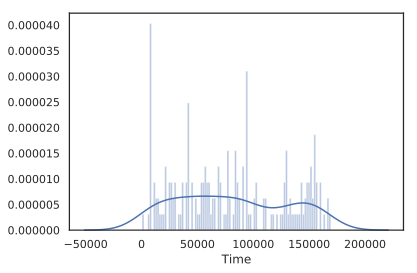

In [19]:
# sns.distplot(df[df['Class']==1]['Time'],100);

In [8]:
# plt.plot(X_old[['V1','V2']].values[Y_old == 0,0], X_old[['V1','V2']].values[Y_old == 0, 1], 'bo', label='non_fraud')
# plt.plot(X_old[['V1','V2']].values[Y_old == 1,0], X_old[['V1','V2']].values[Y_old == 1, 1], 'go', label='fraud')
# plt.legend(loc=0);

## Оценивать модели будем на трех выборках. Сначала на тестовой выборке после SMOT, потом на на выборке, составленной из исходно, но сбалансированной и наконец, на исходной

In [71]:
df = df.sample(n=10000,random_state = r_state)

In [43]:
def all_metrics_validation(model,X,Y):
    print("Accuracy score: "+ str(accuracy_score(Y,model.predict(X))))
    print("ROC AUC score: "+ str(roc_auc_score(Y,model.predict_proba(X)[:,1]))) # нас интересуют положительные результаты
    print("Recall score: "+ str(recall_score(Y,model.predict(X))))

In [44]:
def create_balanced_data_from_initial(data):
    fraud = data[(data['Class']==1)]
    not_fraud = data[(data['Class']==0)]
    new_df=pd.concat([fraud,data[:len(fraud)]])      
    X = new_df.drop(['Class','Time'], axis=1)
    Y = new_df['Class']
    return X,Y

### Для того, что получить сбалансированный датасет, я буду использовать алгоритм ADASYN(Adaptive Synthetic Sampling) . Поскольку SMOTE (Synthetic Minority Over-sampling Technique) создает больше примеров внутри кластера, а ADASYN создает больше синтетических примеров на границе. В таком случае, модели будут уверенно классифицировать транзакции внутри кластера, который уже был, поскольку будут лучше опознавать мошеннические транзакции на границе двух кластеров. Хотя это и может привести к ошибкам рода False Positive, мне кажется, что такой подход будет надежнее. Далее проведется сравнение двух этих алгоритмов

In [60]:
def create_balanced_data_smote(x,y):
    sm = SMOTE(random_state=12, ratio = 'minority')
    X,Y = sm.fit_sample(x, y)
    X = pd.DataFrame(X,columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'] )
    Y = pd.DataFrame(Y,columns = ['Class'])
    return X,Y

In [61]:
def create_balanced_data_adasyn(x,y):
    sm = ADASYN(random_state=12, ratio = 'minority')
    X,Y = sm.fit_sample(x, y)
    X = pd.DataFrame(X,columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'] )
    Y = pd.DataFrame(Y,columns = ['Class'])
    return X,Y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [54]:
X_balanced, Y_balanced = create_balanced_data_from_initial(df)

In [70]:
X_train_adasyn, y_train_adasyn = create_balanced_data_adasyn(X_train, y_train)

In [72]:
X_test_adasyn, y_test_adasyn = create_balanced_data_adasyn(X_test, y_test)

# Случайный лес

In [36]:
%%time
parameters = {'max_features': ['auto'], 'min_samples_leaf': [1, 3],'max_depth': [1,2,3,10],'n_estimators':[10],'n_jobs':[-1]}

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=r_state)

rfc = RandomForestClassifier()

gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)

gcv.fit(X_adasyn, y_adasyn)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    6.2s finished


CPU times: user 11.7 s, sys: 198 ms, total: 11.9 s
Wall time: 8.44 s


In [39]:
clf = gcv.best_estimator_
gcv.best_params_ , gcv.best_score_

({'max_depth': 10,
  'max_features': 'auto',
  'min_samples_leaf': 3,
  'n_estimators': 10,
  'n_jobs': -1},
 0.9967336633068152)

array([[9.99081815e-01, 9.18185468e-04],
       [9.99580335e-01, 4.19665328e-04],
       [9.99428375e-01, 5.71624974e-04],
       ...,
       [9.98112925e-01, 1.88707511e-03],
       [9.92471871e-01, 7.52812877e-03],
       [9.90526440e-01, 9.47355964e-03]])

# Посмотри про индексацию двумерных массивов

In [113]:
all_metrics_validation(clf,X_test,y_test)

Accuracy score: 0.9246776671788363
ROC AUC score: 0.974976419969922
Recall score: 0.850624624223395


# Метод ближайших соседей

In [114]:
%%time
parameters = {'n_neighbors': range(9,10),'n_jobs':[-1]}

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=r_state)

knn = KNeighborsClassifier()

gcv = GridSearchCV(knn, parameters, n_jobs=-1, cv=skf, verbose=1,scoring='recall')

gcv.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.9s finished


CPU times: user 479 ms, sys: 83.9 ms, total: 563 ms
Wall time: 14.4 s


In [115]:
clf = gcv.best_estimator_
gcv.best_params_ , gcv.best_score_

({'n_jobs': -1, 'n_neighbors': 9}, 0.9990983383664181)

In [116]:
all_metrics_validation(clf, X,Y)

Accuracy score: 0.99456
ROC AUC score: 0.980948087286508
Recall score: 0.9424083769633508


# Логистическая регрессия

In [164]:
%%time
parameters = {'C': np.linspace(25,30,20),'n_jobs':[-1]}

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=r_state)

logit = LogisticRegression()
gcv = GridSearchCV(logit, parameters, n_jobs=-1, cv=skf, verbose=1,scoring='recall')

gcv.fit(X_train, y_train)





Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   25.3s finished


CPU times: user 3.67 s, sys: 112 ms, total: 3.79 s
Wall time: 27.1 s


In [165]:
clf = gcv.best_estimator_
gcv.best_params_ , gcv.best_score_

({'C': 29.473684210526315, 'n_jobs': -1}, 0.9253677943786135)

In [166]:
all_metrics_validation(clf, X,Y)

Accuracy score: 0.9698
ROC AUC score: 0.9808624787480213
Recall score: 0.9057591623036649
